***CHÚ Ý***: Tìm hiêu xem số chiều của resnet với mỗi filter là bao nhiêu, liệu ảnh kích thước đầu vào đúng chưa, các layer làm gì, nhất là các layer cuối cùng

kiểm tra xem đã shuffle data sau mỗi epoch chưa

liệu có flatten quá sớm không

[callbacks](https://towardsdatascience.com/tensorflow-callbacks-how-to-monitor-neural-network-training-like-a-pro-f02cb4e477d0) model checkpoint, CSVLogger

test dataset

data augmentation



MAE/MSE/RMSE


chiến lược:


* Xác định trước xem train/val loss/accuracy trước và sau khi hiệu chỉnh là bao nhiêu. Quan trọng vì để xác định khi nào thì đã đủ overfit
* tạo 1 kiến trúc đơn giản.
 * đảm bảo nó overfit trên tập dữ liệu rất bé trước.
 * nếu không thể overfit trên tập dữ liệu lớn:
   * thử các chiến lực giảm learning rate khác nhau (coarse cho nhiều lr trước). Nếu không được:
   * dùng thuật toán tối ưu khác (coarse cho nhiều **tổ hợp** optimizer + lr trước): Adam, SGD, Adadelta (do có thể đang mắc ở các điểm saddle). Nếu không được:
   * thử kiến trúc phức tạp hơn

* Sau khi đảm bảo overfit trên toàn bộ tập dữ liệu rồi: thêm hiệu chỉnh/drop out.
 * đảm bảo nó overfit trên tập dữ liệu rất bé trước.
 * nếu bị underfit trên toàn tập dữ liệu:
   * thử giảm learning rate (coarse...). Nếu không được:
   * dùng các thuật toán tối ưu khác (coarse...). Nếu không được:
   * kiểm tra xem lambda có bị lớn quá không. Nếu không được:
   * thử kiến trúc khác phức tạp hơn



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import

In [1]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11350, done.
remote: Counting objects: 100% (11350/11350), done.
remote: Compressing objects: 100% (11335/11335), done.
remote: Total 11350 (delta 215), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11350/11350), 183.12 MiB | 19.79 MiB/s, done.
Resolving deltas: 100% (215/215), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.regularizers import L1, L2
from keras.models import Model

seed = 42

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop, Nadam
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


### Load images

In [14]:
image_size = (224, 224)
input_shape = (*image_size, 1)
batch_size = 32
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

In [15]:
scores_dataframe.head()

,file_name,score
0,AF1.jpg,2.333333
1,AF2.jpg,3.950000
2,AF3.jpg,3.183333
3,AF4.jpg,2.683333
4,AF5.jpg,2.000000


count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


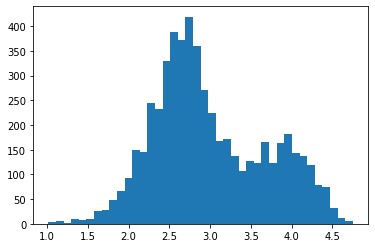

In [16]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40)
plt.show()

In [17]:
genders = [scores_dataframe['file_name'][index][1] for index in scores_dataframe.index]
genders = np.array(genders)
set_seed(seed)
np.random.shuffle(genders)

In [18]:
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size, color_mode="grayscale")
    img = image.img_to_array(img)
    images.append(img/255.)

In [19]:
images = np.array(images)
scores = np.array(scores)

set_seed(seed)

np.random.shuffle(images)
set_seed(seed)
np.random.shuffle(scores)

In [20]:
print(images.shape)
print(scores.shape)

(5500, 224, 224, 1)
(5500,)


In [21]:
b_images = []
b_scores = []
for i in range(5500):
    if scores[i] > 4 and genders[i] == 'F':
        b_images.append(images[i])
        b_scores.append(scores[i])

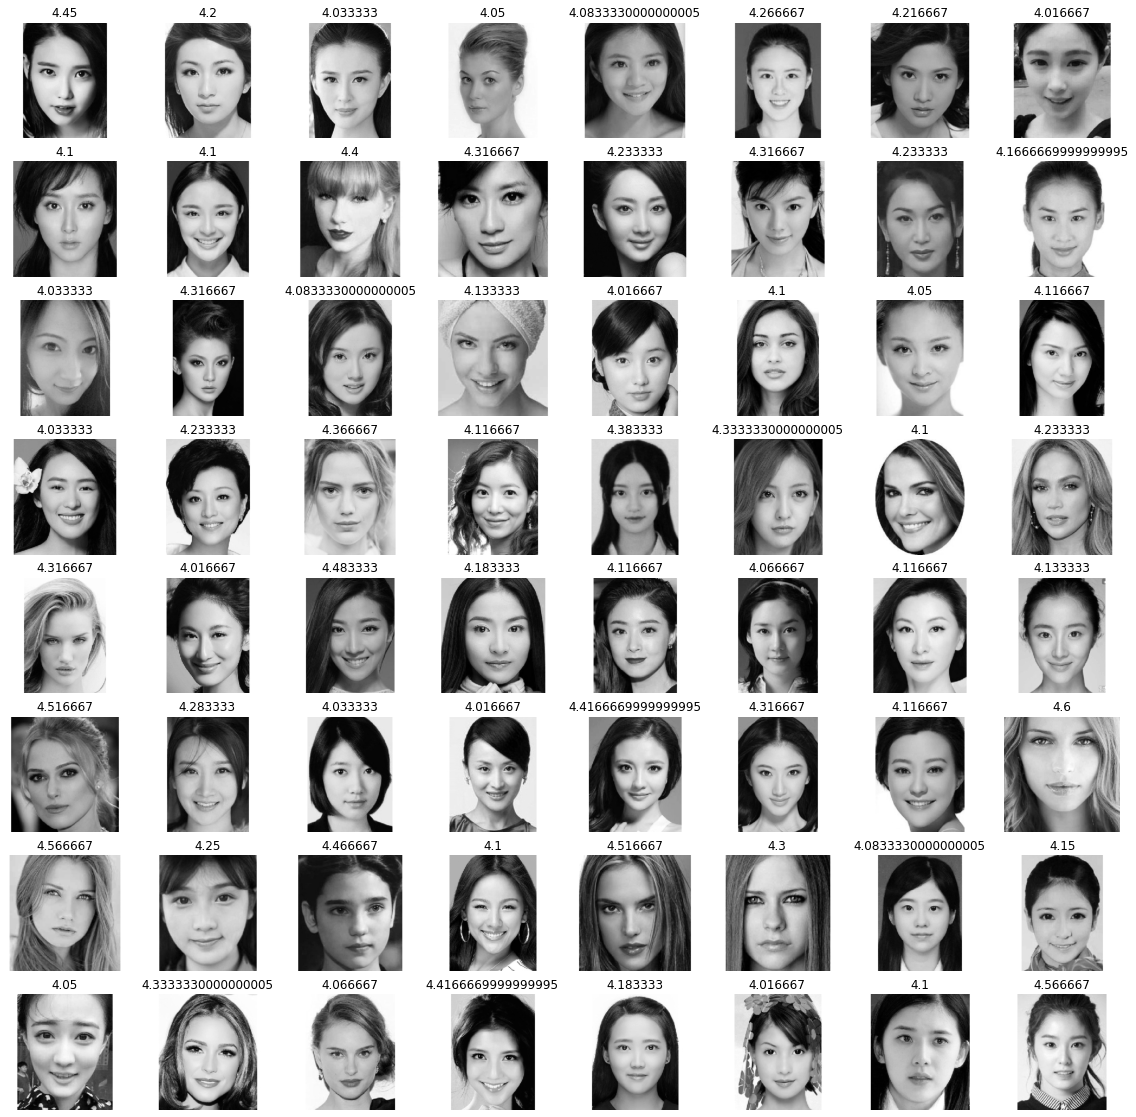

In [22]:
shift = 48
plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(np.squeeze(b_images[i + shift]), cmap='gray')
    plt.title(b_scores[i + shift])
    plt.axis("off")

### Create dataset

In [ ]:
n_train = 4400
v_validation = 1100
buffer_size = 4400


In [ ]:
# images_ds = tf.data.Dataset.from_tensor_slices(images)
# scores_ds = tf.data.Dataset.from_tensor_slices(scores)

# x_train = images_ds.take(n_train)
# x_val = images_ds.skip(n_train)

# y_train = scores_ds.take(n_train)
# y_val = scores_ds.skip(n_train)

In [ ]:
# x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
# y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((images, scores))

train_ds = ds.take(n_train)
val_ds = ds.skip(n_train)

In [ ]:
# del images

In [ ]:
steps_per_epoch = {'tiny': 5,
                   'small': 27,
                   'medium': 64,
                   'large': 100,
                   'all': n_train//batch_size}

In [ ]:
def get_dataset(batch_size, dataset_size='all'):
    set_seed(seed)
    if dataset_size == 'all':
        return (train_ds.cache().shuffle(buffer_size, seed, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE),
                val_ds.cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
                )
    else:
        return (train_ds.take(steps_per_epoch[dataset_size]).cache().shuffle(buffer_size, seed, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE),
                val_ds.take(steps_per_epoch[dataset_size]).cache().batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
                )

### Build architectures

In [ ]:
def identity_block(X, f, filters, training=True):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    set_seed(seed)

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [ ]:
def convolutional_block(X, f, filters, s=2, training=True):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    set_seed(seed)
    
    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet11(input_shape=input_shape):

    set_seed(seed)

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(1, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='ResNet11')

    return model


### Utilities

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
models = {}
lr_record = {}
epoch_record = {}
histories = {}

In [ ]:
def remove_model(name):
    try:
        del models[name]
        del histories[name]
        del lr_record[name]
        del epoch_record[name]
    except:
        pass

In [ ]:
def train_model(name, optimizer, max_epochs, batch_size=32, monitor='val_nonregu_mae', patience=None, dataset_size='all'):

    print(name)

    if patience is None: patience = max_epochs

    if dataset_size == 'all': steps_per_epoch['all'] = n_train//batch_size

    train_data, validation_data = get_dataset(batch_size, dataset_size)

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor=monitor, min_delta=0.00001, patience=int(patience*1.5), verbose=1),
                #  tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/.ipynb_checkpoints/' + name + '-{epoch:02d}-{' + monitor + ':.2f}.hdf5', monitor=monitor, verbose=1, save_best_only=True),
                 tf.keras.callbacks.TensorBoard(logdir/name)
                ]
    
    shutil.rmtree(logdir/name, ignore_errors=True)     

    new_model = True
    if name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(name)) != 'y':
        new_model = False
    
    
    
    set_seed(seed)

    if new_model:

        models[name].compile(
            optimizer=optimizer,
            loss='mean_absolute_error',
            metrics=[tf.keras.losses.MeanAbsoluteError(name='nonregu_mae')]
        )

        histories[name] = models[name].fit(
            train_data,
            steps_per_epoch=steps_per_epoch[dataset_size],
            epochs=max_epochs,
            validation_data=validation_data,
            callbacks=callbacks
        )

        epoch_record[name] = [histories[name].epoch[-1]]
        lr_record[name] = [optimizer.get_config()['learning_rate']]

    else:

        models[name].optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])

        cont_history = models[name].fit(
            train_data, 
            steps_per_epoch=steps_per_epoch[dataset_size],     
            epochs=max_epochs,     
            validation_data=validation_data,    
            callbacks=callbacks,
            initial_epoch=histories[name].epoch[-1] + 1
        )

        epoch_record[name].append(cont_history.epoch[-1])
        lr_record[name].append(optimizer.get_config()['learning_rate'])
        histories[name].epoch += cont_history.epoch
        histories[name].history['loss'] += cont_history.history['loss']
        histories[name].history['val_loss'] += cont_history.history['val_loss']
        histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
        histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

    

    return name

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ety6h0e_
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ety6h0e_


In [ ]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

In [ ]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

### Testing

#### plot activation distribution

In [ ]:
model = ResNet11(input_shape)
plot_activations(model, images[1])

#### Xác định

Regu|Train loss| Test loss
-|-|-
có|0.01|0.05
không|0.001|

In [ ]:
keras.models.clone_model(models['ResNet50_Adam_lr_0.0005']).save('/content/drive/MyDrive/overfit_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/overfit_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# models['ResNet50_Adam_lr_0.0005'] = tf.keras.models.load_model('/content/drive/MyDrive/overfit_model')

In [ ]:
# import pickle
# import sys
# sys.setrecursionlimit(15000)
# history_dict = {name: histories[name].history for name in histories.keys()}
# with open('/content/drive/MyDrive/histories', 'wb') as file_pi:
#         pickle.dump(history_dict, file_pi)
# history_dict = pickle.load(open('/content/drive/MyDrive/histories', 'rb'))

#### Thử overfit ResNet11 trên tập dữ liệu rất bé

In [ ]:
optimizer = Adam(learning_rate=1e-5)

model = ResNet11()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = Adam(learning_rate=1e-10)
train_model(name, optimizer, max_epochs=190, monitor='nonregu_mae', patience=8, dataset_size='tiny')

{'ResNet11_Adam_lr_1e-05': [1e-10]}
{'ResNet11_Adam_lr_1e-05': [12, 49, 99, 147, 169, 189]}


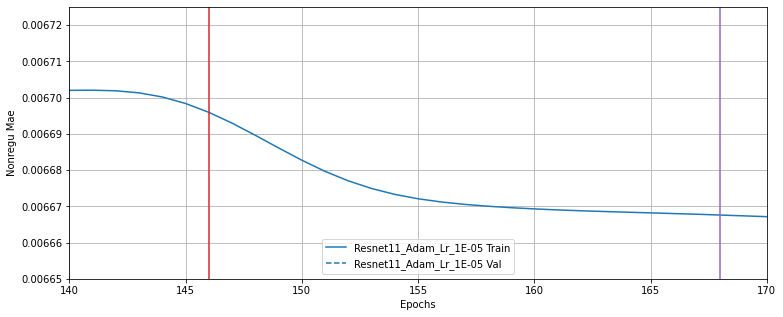

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
plt.xlim([140, 170])
plt.ylim([0.00665, 0.006725])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

===> có vẻ như ResNet11 không thể overfit đến mức 0.001 train loss được, thử optimizer khác có lẽ cũng không được chắc phải tăng capacity

#### Thử dùng thuật toán khác

In [ ]:
# l = None
# lr = 5e-2
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

model = ResNet11()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(learning_rate=1e-11, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=250, monitor='nonregu_mae', patience=1
            0, dataset_size='tiny')

{'ResNet50_Adam_lr_1e-05': [1e-05, 0.001], 'ResNet11_SGD_lr_0.001': [0.001, 1e-04, 1e-05, 1e-07, 1e-09, 9.9999994e-11, 1e-11, 9.9999994e-11, 1e-12]}
{'ResNet50_Adam_lr_1e-05': [17, 28], 'ResNet11_SGD_lr_0.001': [32, 54, 70, 95, 119, 132, 145, 199, 215]}


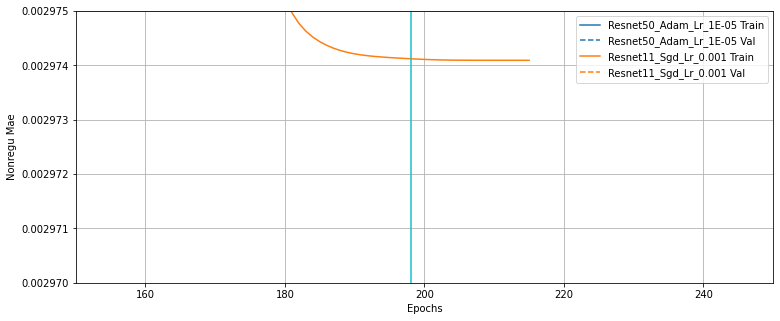

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
plt.xlim([150, 250])
plt.ylim([0.00297, 0.002975])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

===> có vẻ như ResNet11 không thể overfit đến mức 0.001 train loss được, thử optimizer khác cũng không được chắc phải tăng capacity

#### Tạo ResNet50 (do không overfit tập rất bé được)

In [ ]:
def ResNet50(input_shape=input_shape):

    set_seed(seed)

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(1, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

#### Thử overfit ResNet50 trên tập dữ liệu rất bé

In [ ]:
optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

model = ResNet50()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(learning_rate=1e-7, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=150, monitor='nonregu_mae', patience=10, dataset_size='tiny')

ResNet50_SGD_lr_0.001
'ResNet50_SGD_lr_0.001' already exists. Override? [y/n] 


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 101/150
5/5 [==============================] - 10s 970ms/step - loss: 7.1851e-04 - nonregu_mae: 7.1851e-04 - val_loss: 0.9217 - val_nonregu_mae: 0.9217
Epoch 102/150
5/5 [==============================] - 2s 399ms/step - loss: 4.9290e-04 - nonregu_mae: 4.9290e-04 - val_loss: 0.9214 - val_nonregu_mae: 0.9214
Epoch 103/150
5/5 [==============================] - 2s 401ms/step - loss: 4.6970e-04 - nonregu_mae: 4.6970e-04 - val_loss: 0.9209 - val_nonregu_mae: 0.9209
Epoch 104/150
5/5 [==============================] - 2s 408ms/step - loss: 3.6066e-04 - nonregu_mae: 3.6066e-04 - val_loss: 0.9205 - val_nonregu_mae: 0.9205
Epoch 105/150
5/5 [==============================] - 2s 412ms/step - loss: 3.1674e-04 - nonregu_mae: 3.1674e-04 - val_loss: 0.9202 - val_nonregu_mae: 0.9202
Epoch 106/150
5/5 [==============================] - 2s 410ms/step - loss: 2.5416e-04 - nonregu_mae: 2.5416e-04 - val_loss: 0.9199 - val_nonregu_mae: 0.9199
Epoch 107/150
5/5 [==============================] - 2s 4

'ResNet50_SGD_lr_0.001'

{'ResNet50_SGD_lr_0.001': [1.0000001e-05, 1e-06, 1e-07, 9.9999994e-11]}
{'ResNet50_SGD_lr_0.001': [49, 59, 99, 149]}


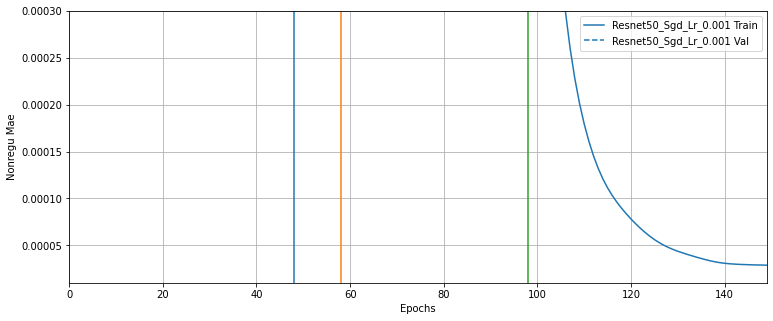

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
plt.ylim([0.00001, 0.0003])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

===> có vẻ như ResNet50 overfit quá tốt cho tiny: < 0.00005 train loss được

#### Thử overfit ResNet50 trên tập dữ liệu đầy đủ

In [ ]:
optimizer = SGD(learning_rate=5e-3, momentum=0.9, nesterov=True)

model = ResNet50()

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(learning_rate=5e-5, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=350, monitor='nonregu_mae', patience=10, batch_size=128)

{'ResNet50_SGD_lr_0.005': [4.9999995e-05, 5e-05, 5e-05, 5e-05, 5e-05, 5e-06]}
{'ResNet50_SGD_lr_0.005': [105, 119, 149, 199, 249, 320]}


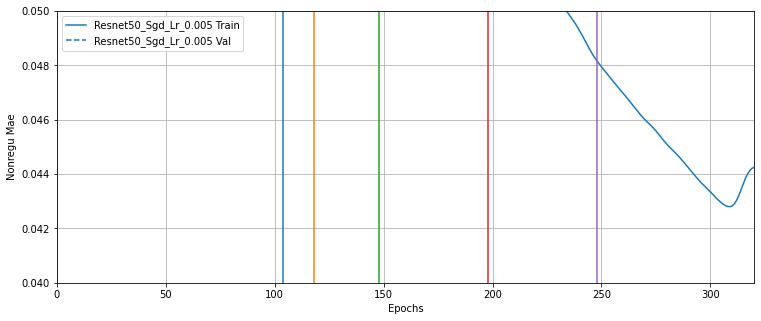

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
plt.ylim([0.04, 0.05])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

===> có vẻ khó overfit đến mức 0.001 được

#### coarse optimizer khác

In [ ]:
def coarse(model, optimizer, max_epochs, monitor, patience):
    name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
    models[name] = model
    train_model(name, optimizer, max_epochs=max_epochs, monitor=monitor, patience=patience, batch_size=128)

In [ ]:
coarse(ResNet50(), Adam(learning_rate=5e-3), 30, monitor='nonregu_mae', patience=5)

In [ ]:
coarse(ResNet50(), Adam(learning_rate=5e-4), 2, monitor='nonregu_mae', patience=5)

In [ ]:
coarse(ResNet50(), Adadelta(learning_rate=5e-3), 30, monitor='nonregu_mae', patience=5)

In [ ]:
coarse(ResNet50(), Adadelta(learning_rate=5e-4), 30, monitor='nonregu_mae', patience=5)

In [ ]:
coarse(ResNet50(), SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 30, monitor='nonregu_mae', patience=5)

In [ ]:
coarse(ResNet50(), SGD(learning_rate=1e-5, momentum=0.9, nesterov=True), 30, monitor='nonregu_mae', patience=5)

chọn Adam lr=5e-4 để đi tiếp

In [ ]:
train_model('ResNet50_Adam_lr_0.0005', Adam(learning_rate=5e-9), max_epochs=500, monitor='nonregu_mae', patience=20, batch_size=128)

{'ResNet50_Adam_lr_0.0005': [0.0005, 0.0005, 5e-06, 5e-07, 5e-09]}
{'ResNet50_Adam_lr_0.0005': [1, 125, 299, 364, 429]}


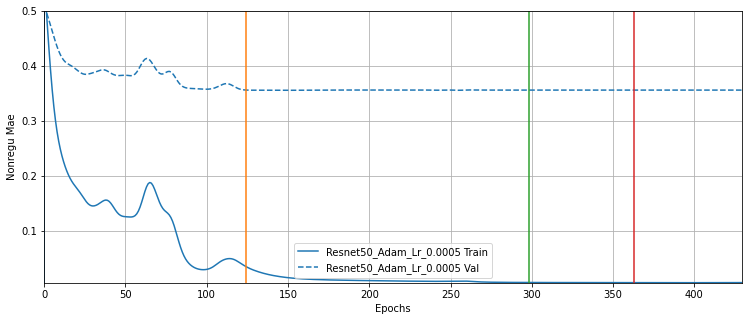

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 100])
plt.ylim([0.005, 0.5])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

0.005 (train) - 0.37 (val)

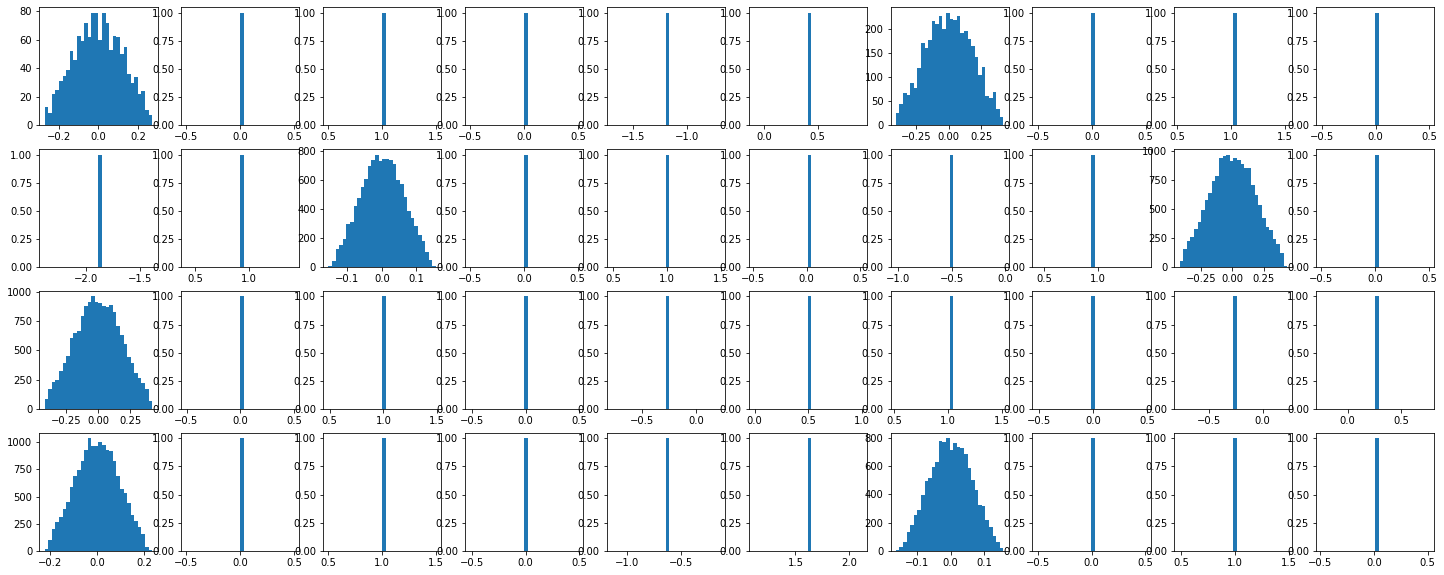

In [ ]:
plt.figure(figsize=(25, 10))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.hist(models['ResNet50_Adam_lr_0.0005'].get_weights()[i][0].reshape(-1,), bins=30)

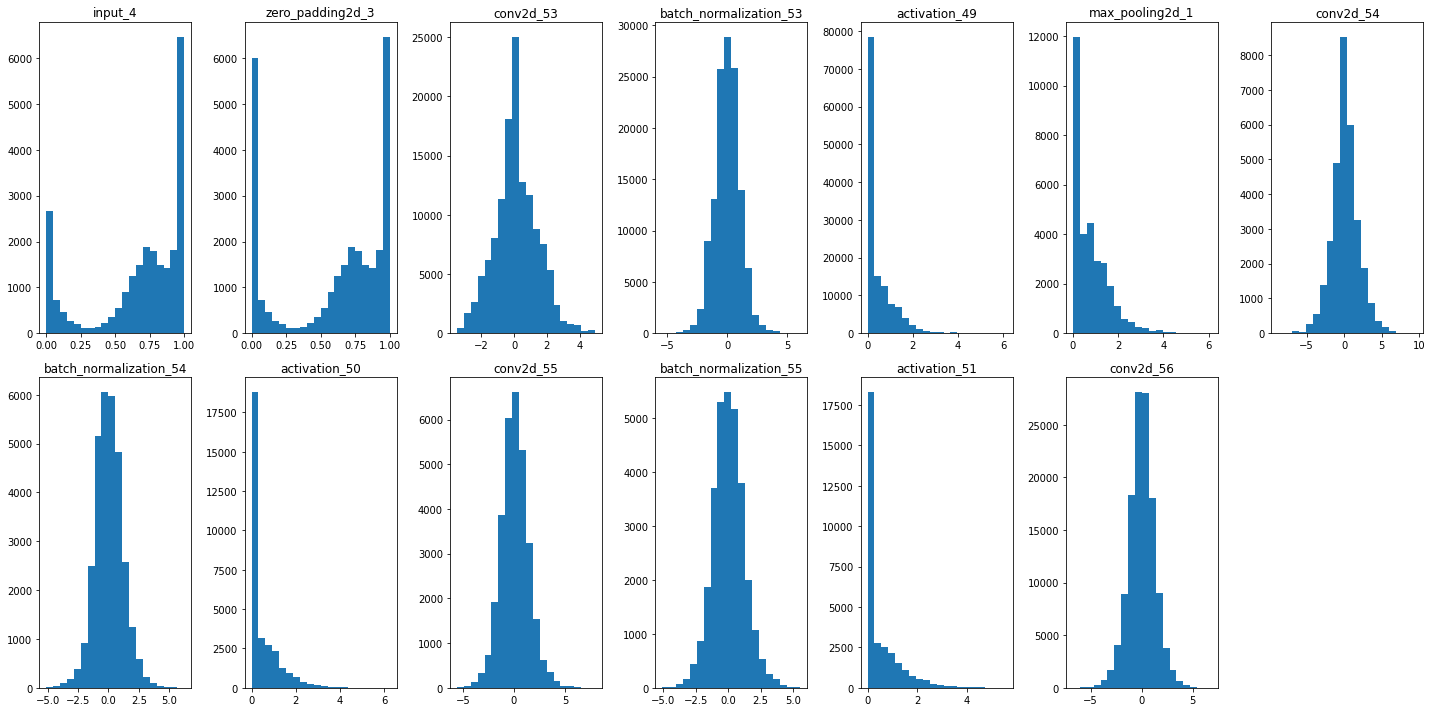

In [ ]:
plot_activations(models['ResNet50_Adam_lr_0.0005'], images[24])

In [ ]:
weights = [w[0].reshape(-1,) for w in models['ResNet50_Adam_lr_0.0005'].get_weights()]

In [ ]:
sum([np.sum(np.square(w)) for w in weights])

56982.41215229624

#### Tạo ResNet50 regu

In [ ]:
def identity_block_regu(X, f, filters, training=True, l=None, dropout_rate=0):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    set_seed(seed)

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [ ]:
def convolutional_block_regu(X, f, filters, s=2, training=True, l=None, dropout_rate=0):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    set_seed(seed)

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50_regu(input_shape=input_shape, l=None, dropout_rate=0):

    set_seed(seed)

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], l=l, dropout_rate=dropout_rate)

    # stage 3
    X = convolutional_block_regu(X, f=3, filters=[128, 128, 512], s=2, l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], l=l, dropout_rate=dropout_rate)

    # stage 4
    X = convolutional_block_regu(X, f=3, filters=[256, 256, 1024], s=2, l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], l=l, dropout_rate=dropout_rate)

    # stage 5
    X = convolutional_block_regu(X, f=3, filters=[512, 512, 2048], s=2, l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], l=l, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], l=l, dropout_rate=dropout_rate)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(1000, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(42, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50_L2_{}_drop_{}'.format(str(l.l2 if l is not None else 0), dropout_rate))

    return model


#### Thử overfit trên tập rất bé

In [ ]:
optimizer = SGD(5e-4, momentum=0.9, nesterov=True)

model = ResNet50_regu(l=L2(2e-6), dropout_rate=0.5)

name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
models[name] = model

In [ ]:
optimizer = SGD(5e-6, momentum=0.9, nesterov=True)
train_model(name, optimizer, max_epochs=150, monitor='loss', patience=15, dataset_size='tiny')

ResNet50_L2_2e-06_drop_0.5_SGD_lr_0.0005


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/150
5/5 [==============================] - 20s 2s/step - loss: 5.8874 - nonregu_mae: 5.7768 - val_loss: 1.7359 - val_nonregu_mae: 1.6253 - lr: 5.0000e-06
Epoch 2/150
5/5 [==============================] - 7s 2s/step - loss: 3.1314 - nonregu_mae: 3.0209 - val_loss: 0.5316 - val_nonregu_mae: 0.4211 - lr: 5.0000e-06
Epoch 3/150
5/5 [==============================] - 7s 2s/step - loss: 2.2376 - nonregu_mae: 2.1271 - val_loss: 1.0792 - val_nonregu_mae: 0.9687 - lr: 5.0000e-06
Epoch 4/150
5/5 [==============================] - 7s 2s/step - loss: 1.9223 - nonregu_mae: 1.8117 - val_loss: 1.3464 - val_nonregu_mae: 1.2359 - lr: 5.0000e-06
Epoch 5/150
5/5 [==============================] - 7s 2s/step - loss: 1.8501 - nonregu_mae: 1.7396 - val_loss: 1.6193 - val_nonregu_mae: 1.5088 - lr: 5.0000e-06
Epoch 6/150
5/5 [==============================] - 7s 2s/step - loss: 1.6450 - nonregu_mae: 1.5345 - val_loss: 1.5784 - val_nonregu_mae: 1.4679 - lr: 5.0000e-06
Epoch 7/150
5/5 [================

'ResNet50_L2_2e-06_drop_0.5_SGD_lr_0.0005'

{'ResNet50_L2_2e-05_drop_0.5_SGD_lr_5e-05': [0.0005, 0.0005, 0.0005, 0.0005, 5e-05, 5e-05], 'ResNet50_L2_2e-05_drop_0.5_SGD_lr_0.0005': [5.0000002e-05, 5e-06], 'ResNet50_L2_2e-06_drop_0.5_SGD_lr_0.0005': [5e-07]}
{'ResNet50_L2_2e-05_drop_0.5_SGD_lr_5e-05': [19, 39, 99, 199, 222, 245], 'ResNet50_L2_2e-05_drop_0.5_SGD_lr_0.0005': [99, 149], 'ResNet50_L2_2e-06_drop_0.5_SGD_lr_0.0005': [82]}


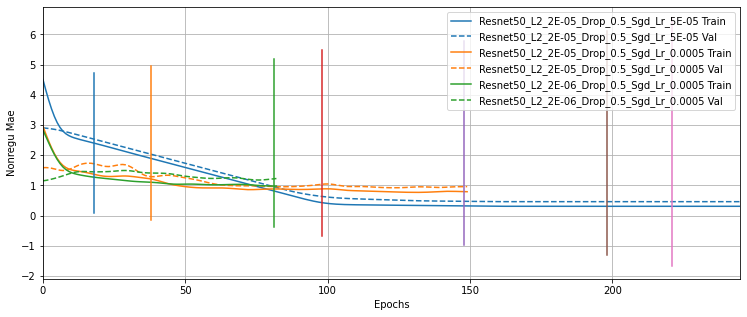

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 100])
# plt.ylim([0, 2])
plt.xlabel('Epochs')
print(lr_record)
print(epoch_record)

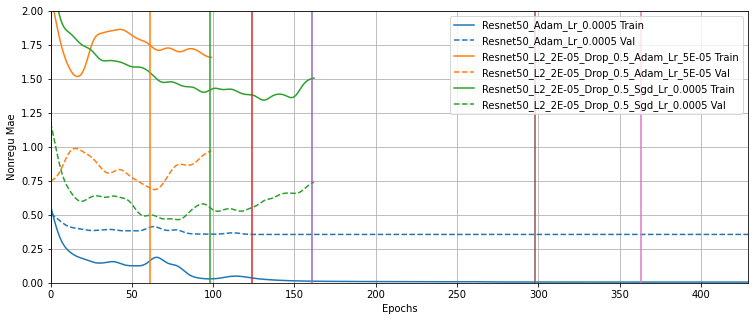

#### make sure can overfit

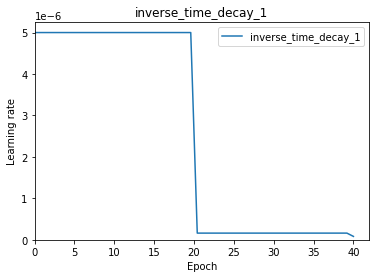

In [ ]:
inverse_time_decay_1 = InverseTimeDecay(
    initial_learning_rate=5e-6,
    decay_steps=steps_per_epoch*20,
    decay_rate=30,
    staircase=True,
    name='inverse_time_decay_1'
)

step = np.linspace(0, steps_per_epoch * max_epochs)

plot_learning_rate(step, inverse_time_decay_1)

#### testing

In [ ]:
# Testing learning rate
l = L2(0.001)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)


loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.7346019


In [ ]:
# check if the regu term is present

model.layers[2].get_config()

first, we check with tiny dataset

if the training is terminated because of callback, adjust the learning rate to smaller



In [ ]:
l = L2(0.001)

patience = 10
max_epochs = 20
steps_per_epoch = 5


lr = 1e-4
name = 'regu_0.001_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

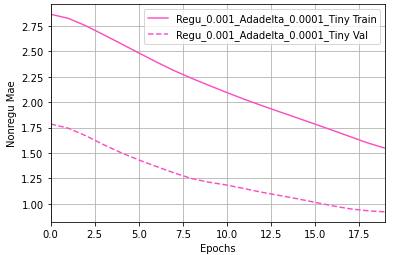

với 20 epochs fit khá tốt với tiny. nếu train thêm chắc sẽ overfit được

#### thử xem model gốc có overfit được toàn bộ tập data không

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
histories = {}

In [ ]:
patience = 10   # 10?
max_epochs = 20
steps_per_epoch = n_train // batch_size

l = None
lr = 5e-4
name = 'adadelta_lr_{}'.format(lr)


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
patience = 30
max_epochs = 40

lr = 5e-6

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name),
    initial_epoch=histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
histories[name].epoch += cont_history.epoch
histories[name].history['loss'] += cont_history.history['loss']
histories[name].history['val_loss'] += cont_history.history['val_loss']
histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

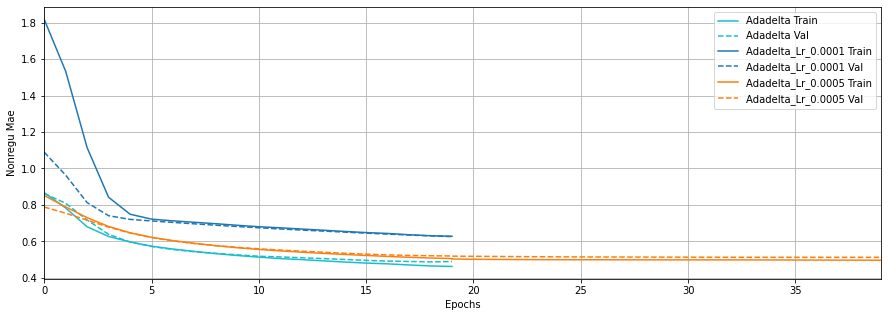

In [ ]:
plt.figure(figsize=(15, 5))
plotter.plot(histories)
# for i in range(len(epoch_record) - 1):
#     plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

thay đổi lr không có ích gì, thử đổi sang optiizer khác xem sao

#### Deeper net

In [ ]:
def ResNet50(input_shape=(64, 64, 3), dropout_rate=0):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)

    # stage 3
    X = convolutional_block_regu(X, f=3, filters=[128, 128, 512], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[128, 128, 512], dropout_rate=dropout_rate)

    # stage 4
    X = convolutional_block_regu(X, f=3, filters=[256, 256, 1024], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[256, 256, 1024], dropout_rate=dropout_rate)

    # stage 5
    X = convolutional_block_regu(X, f=3, filters=[512, 512, 2048], s=2, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[512, 512, 2048], dropout_rate=dropout_rate)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

#### thử overfit

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

coarse

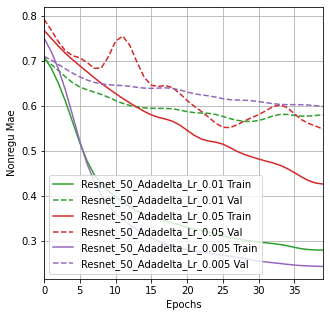

In [ ]:
# l = None
# lr = 5e-2
# optimizer = Adadelta(learning_rate=lr)

# model = ResNet50(input_shape, dropout_rate=0.5)

# name = '{}_{}_lr_{}'.format(model.name, optimizer.get_config()['name'], optimizer.get_config()['learning_rate'])
# models[name] = model


    


In [ ]:
train_model(name, optimizer, max_epochs=5, patience=10, dataset_size='tiny')

'ResNet11_L2_0_drop_0.5_Adadelta_lr_0.05' already exists. Override? [y/n] y
new_model


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
5/5 [==============================] - 7s 1s/step - loss: 1.8761 - nonregu_mae: 1.8761 - val_loss: 0.6880 - val_nonregu_mae: 0.6880
Epoch 2/5
5/5 [==============================] - 6s 1s/step - loss: 2.0422 - nonregu_mae: 2.0422 - val_loss: 1.2003 - val_nonregu_mae: 1.2003
Epoch 3/5
5/5 [==============================] - 6s 1s/step - loss: 1.8295 - nonregu_mae: 1.8295 - val_loss: 1.2270 - val_nonregu_mae: 1.2270
Epoch 4/5
5/5 [==============================] - 6s 1s/step - loss: 1.7963 - nonregu_mae: 1.7963 - val_loss: 1.0833 - val_nonregu_mae: 1.0833
Epoch 5/5
5/5 [==============================] - 6s 1s/step - loss: 1.8732 - nonregu_mae: 1.8732 - val_loss: 1.0459 - val_nonregu_mae: 1.0459


'ResNet11_L2_0_drop_0.5_Adadelta_lr_0.05'

In [ ]:
patience = 30   # 10?
max_epochs = 200
steps_per_epoch = n_train // batch_size

l = None
lr = 5e-2
name = 'resnet_50_adadelta_lr_{}'.format(lr)


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape)

histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    # callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Epoch 1/200
68/68 [==============================] - 55s 276ms/step - loss: 0.8396 - nonregu_mae: 0.8396 - val_loss: 0.7187 - val_nonregu_mae: 0.7184
Epoch 2/200
68/68 [==============================] - 17s 248ms/step - loss: 0.7518 - nonregu_mae: 0.7518 - val_loss: 0.7510 - val_nonregu_mae: 0.7472
Epoch 3/200
68/68 [==============================] - 17s 247ms/step - loss: 0.7165 - nonregu_mae: 0.7165 - val_loss: 0.8891 - val_nonregu_mae: 0.8872
Epoch 4/200
68/68 [==============================] - 17s 247ms/step - loss: 0.7134 - nonregu_mae: 0.7134 - val_loss: 0.6944 - val_nonregu_mae: 0.6901
Epoch 5/200
68/68 [==============================] - 17s 246ms/step - loss: 0.6399 - nonregu_mae: 0.6399 - val_loss: 0.6483 - val_nonregu_mae: 0.6465
Epoch 6/200
68/68 [==============================] - 17s 246ms/step - loss: 0.6849 - nonregu_mae: 0.6849 - val_loss: 0.7307 - val_nonregu_mae: 0.7327
Epoch 7/200
68/68 [==============================] - 17s 246ms/step - loss: 0.6892 - nonregu_mae: 0.

'/content/facial_beauty_perception/saved_model.zip'

In [ ]:
model.save('/content/drive/MyDrive/overfit_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/overfit_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/overfit_model', model.get_config())

In [ ]:
import pickle
import sys
sys.setrecursionlimit(15000)
with open('/content/drive/MyDrive/model_weights', 'wb') as file_pi:
        pickle.dump(model.get_weights(), file_pi)

In [ ]:
weights = [w[0].reshape(-1,) for w in model.get_weights()]

In [ ]:
sum([np.sum(np.square(w)) for w in weights])

51110.02806738655

In [ ]:
model.get_config()

Text(0.5, 0, 'Epochs ([0.05, 0.005])')

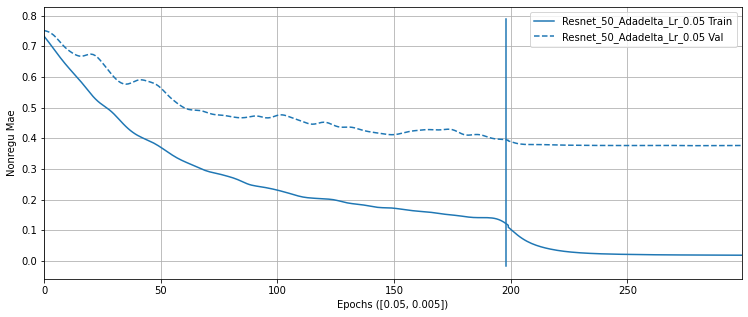

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs ({})'.format(lr_record))        # <---- add [Log scale]

#### thử resnet với regu

In [ ]:
l = L2(0.01)

# model dropout
model = ResNet50(input_shape, dropout_rate=0.5)

optimizer = Adadelta(learning_rate=5e-2)

loss_value, gradients = grad(model, images[:64], scores[:64])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:64], scores[:64])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:64], scores[:64])

print(loss_value.numpy())

2.8561416
2.1024299
1.9927382


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/40
5/5 [==============================] - 11s 1s/step - loss: 2.1690 - nonregu_mae: 2.1690 - val_loss: 1.7561 - val_nonregu_mae: 1.7561
Epoch 2/40
5/5 [==============================] - 2s 406ms/step - loss: 1.9614 - nonregu_mae: 1.9614 - val_loss: 2.1608 - val_nonregu_mae: 2.1608
Epoch 3/40
5/5 [==============================] - 2s 401ms/step - loss: 1.7601 - nonregu_mae: 1.7601 - val_loss: 2.3098 - val_nonregu_mae: 2.3098
Epoch 4/40
5/5 [==============================] - 2s 411ms/step - loss: 1.5801 - nonregu_mae: 1.5801 - val_loss: 2.5750 - val_nonregu_mae: 2.5750
Epoch 5/40
5/5 [==============================] - 2s 412ms/step - loss: 1.4402 - nonregu_mae: 1.4402 - val_loss: 2.3304 - val_nonregu_mae: 2.3304
Epoch 6/40
5/5 [==============================] - 2s 410ms/step - loss: 1.3095 - nonregu_mae: 1.3095 - val_loss: 1.7885 - val_nonregu_mae: 1.7885
Epoch 7/40
5/5 [==============================] - 2s 397ms/step - loss: 1.1886 - nonregu_mae: 1.1886 - val_loss: 1.3859 - val_

Text(0.5, 0, 'Epochs')

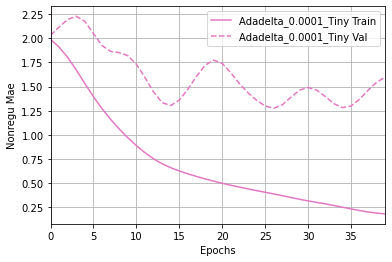

In [ ]:
patience = 40
max_epochs = 40
steps_per_epoch = 5

lr = 1e-4
l = None

name = 'resnet_50_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape) #, dropout_rate=0.5)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
histories = {}

In [ ]:
patience = 30   # 10?
max_epochs = 100
steps_per_epoch = n_train // batch_size

l = L2(0.01)
name = 'resnet_50_adadelta'
lr = 1e-2


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape, dropout_rate=0.5)

histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
# text = """..."""
# text_2 = text.split('\n')

# stat = np.array([text_2[2*i + 1].split()[7:11:3] for i in range(len(text_2) // 2)], dtype='float32')

# print(np.corrcoef(stat[:,0], stat[:,1]))


loss nonregu đi xuống rất chậm mặc dù loss tổng xuống đều, liệu có phải lambda bị lớn quá?

In [ ]:
patience = 30   # 10?
max_epochs = 100
steps_per_epoch = n_train // batch_size

l = L2(0.001)
name = 'resnet_50_l2_{}_adadelta'.format(l.get_config()['l2'])
lr = 5e-1


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet50(input_shape, dropout_rate=0.5)

histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

ohhhh sau khi hạ lambda thì đúng là tốt hơn nhiều này, giờ thử giảm lr xem sao

In [ ]:
patience = 10
max_epochs = 200

lr = 5e-5

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
histories[name].epoch += cont_history.epoch
histories[name].history['loss'] += cont_history.history['loss']
histories[name].history['val_loss'] += cont_history.history['val_loss']
histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

[0.5, 0.05, 0.005, 5e-05]


Text(0.5, 0, 'Epochs')

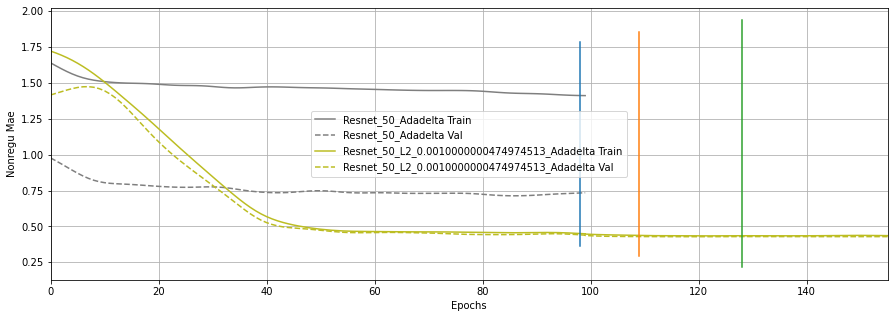

In [ ]:
print(lr_record)

plt.figure(figsize=(15, 5))
plotter.plot(histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

thay đổi lr không có ích gì, thử đổi sang optiizer khác xem sao

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
predictions = tf.data.Dataset.from_tensor_slices(model.predict(val_ds_prefetch)).batch(batch_size)

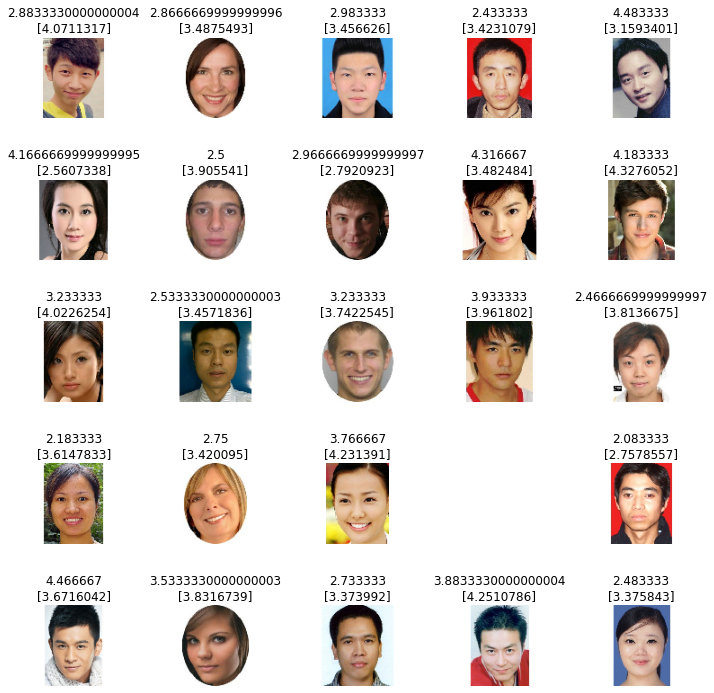

In [ ]:
plt.figure(figsize=(10, 10))
for images, true_scores in val_ds_prefetch.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])
            plt.title('{}\n{}'.format(true_scores[i], pred_scores[i]))
            plt.tight_layout()
            plt.axis("off")